In [1]:
import torch
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
import os
import base64
from PIL import Image
import io
from dataProcessor import process_metadata, pew_metadata_path, statista_metadata_path
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
import torch
import torch.nn.functional as F
from torch import Tensor

/home/mleshashi/thesis-sharma/sraEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path)
combined_df.shape

(29354, 4)

In [3]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img

In [4]:
# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the tokenizer and quantized model
tokenizer = AutoTokenizer.from_pretrained('Alibaba-NLP/gte-Qwen2-7B-instruct', trust_remote_code=True)
model = AutoModel.from_pretrained(
    'Alibaba-NLP/gte-Qwen2-7B-instruct', trust_remote_code=True,
    quantization_config=quantization_config,
    device_map="auto"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 7/7 [00:16<00:00,  2.31s/it]


In [5]:
# Correctly formatted URL for a local Elasticsearch instance
es = Elasticsearch(["http://localhost:9200"])

# define the index name
index_name = "documents"

In [6]:
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},  # Storing Base64-encoded image data
                "gte_embedding": {"type": "dense_vector", "dims":3584}
            }
        }
    })

In [7]:
# Ensure inputs are moved to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move the model to the appropriate device if needed
print(f"Model is on device: {next(model.parameters()).device}")

# Define the maximum length for the input text
max_length = 1250

Using device: cuda
Model is on device: cuda:0


In [8]:
# Function to perform last token pooling on hidden states based on the attention mask.
# It handles cases with left or right padding.
def last_token_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]
    
    
# Function to format a detailed instruction string from a task description and query.
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# Function to embed texts
def embed_texts(texts):
    input_token = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
    input_token = {k: v.to(device) for k, v in input_token.items()}
    with torch.no_grad():  # Ensure no gradients are calculated
        outputs = model(**input_token)
        embeddings = last_token_pool(outputs.last_hidden_state, input_token['attention_mask'])
        embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings.detach().cpu().numpy().flatten().tolist()

In [16]:
# Indexing the documents into embeddings using Elasticsearch with its unique ID, ensuring no duplicates are created.
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Concatenate title and caption with a space or some delimiter
    combined_text = f"{row['title']}. {row['caption']}"
    
    # Generate embedding for the combined text
    embedding = embed_texts(combined_text)

    # Generate a unique ID for the document using a hash of the title and caption
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # update the document in the index with the gte embedding
    es.update(index=index_name, id=unique_id, body={
        "doc": {
            "gte_embedding": embedding
        }
    })
    
    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Optional: Clear variables if no longer needed
    del combined_text, embedding, unique_id

100%|██████████| 29354/29354 [2:16:28<00:00,  3.58it/s]  


In [9]:
doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index: {doc_count}")

Number of documents in the index: 29348


In [20]:
# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Assuming initialization and index creation as before
topics_df = pd.read_csv('../dataset/classified_questions.csv')

# Dictionary to hold total similarity scores for each topic
topic_similarity_scores = {}

for _, row in tqdm(topics_df.iterrows(), total=topics_df.shape[0], desc="Processing topics"):
    question = row['Question']
    query = get_detailed_instruct(task, question)
    query_embedding = embed_texts(query)
    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'gte_embedding') + 1.0",
                "params": {"query_vector": query_embedding}
            }
        }
    }
    
    response = es.search(index=index_name, body={
        "size": 30,  # You might want to adjust this size based on your needs
        "query": script_query,
        "_source": {"includes": ["title", "content"]}  # Include the image data in the response
    })

    # Sum up the scores of all hits for this topic
    total_score = sum(hit['_score'] for hit in response['hits']['hits'])
    topic_similarity_scores[question] = total_score

    # Rank topics by their total similarity score
sorted_topics = sorted(topic_similarity_scores.items(), key=lambda x: x[1], reverse=True)

Processing topics: 100%|██████████| 12061/12061 [53:41<00:00,  3.74it/s] 


In [21]:
# Output the top 10 relevant topics
print("Top 10 Relevant Topics Based on Similarity Score:")
for i, (topic, score) in enumerate(sorted_topics[:12061], 1):
    print(f"{i}. Topic: {topic}, Total Similarity Score: {score}")


Top 10 Relevant Topics Based on Similarity Score:
1. Topic: Is a 5.7 infant mortality rate per 1,000 live births in Saudi Arabia a, Total Similarity Score: 49.93076719999999
2. Topic: Is a 15.7 infant mortality rate per 1,000 live births in Trinidad and Tob, Total Similarity Score: 49.531235599999995
3. Topic: Does the travel and tourism industry have a significant impact on Europe's GDP?, Total Similarity Score: 49.4815166
4. Topic: Has the COVID-19 pandemic increased online shopping among consumers in the Philippines?, Total Similarity Score: 49.265723600000015
5. Topic: Is a 12.2 infant mortality rate per 1,000 live births in Mexico unaccept, Total Similarity Score: 49.033040400000004
6. Topic: Does the COVID-19 pandemic lead to increased grocery sales?, Total Similarity Score: 48.99327949999999
7. Topic: Is a 2.9% youth unemployment rate in Uganda considered low?, Total Similarity Score: 48.978201699999985
8. Topic: Are natural gas prices for households in Italy too high?, Total Si

In [22]:
# Create a DataFrame with the top relevant topics and their similarity scores
topics_df = pd.DataFrame(sorted_topics[:12061], columns=['Topic', 'Similarity Score'])
# Specify the full path for saving the CSV file
csv_path = '../dataset/TopRelevant_topics1.csv'
# Save the DataFrame to the specified CSV file path
topics_df.to_csv(csv_path, index=False)

print("Top relevant topics saved to TopRelevant_topics.csv")

Top relevant topics saved to TopRelevant_topics.csv


***Retriving the top context from a random topic***

In [12]:
# Select a random topic
import random   
topics_df = pd.read_csv('../dataset/TopRelevant_topics1.csv')   
question = random.choice(topics_df['Topic'].to_list())
#question= 'Are gas prices too high?'

# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Generate the detailed instruction string
query = get_detailed_instruct(task, question)
query_embedding = embed_texts(query)

# Define the script query for Elasticsearch
query

'Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery: Should social networks be banned?'

Top 3 relevant documents for the topic 'Should social networks be banned?':

1. Title: 
                        Internet users who do not support temporary social media shutdowns during times of crisis because they are the primary source of news and information for many people as of June 2019, by country
                    
   Content:  In April 2019, the Sri Lankan government cut off social media access in the wake of a fatal terrorist attack. According to an Ipsos survey conducted a month later, a total of 62 of the respondents stated that temporarily cutting off social media platforms during times of crisis is unacceptable given that many people relied on them for news and information. Peru and Turkey were ranked first in their disagreement with this action, with 74 percent of respondents from both countries citing a temporary social media band as unacceptable. 
   Score: 1.4483391



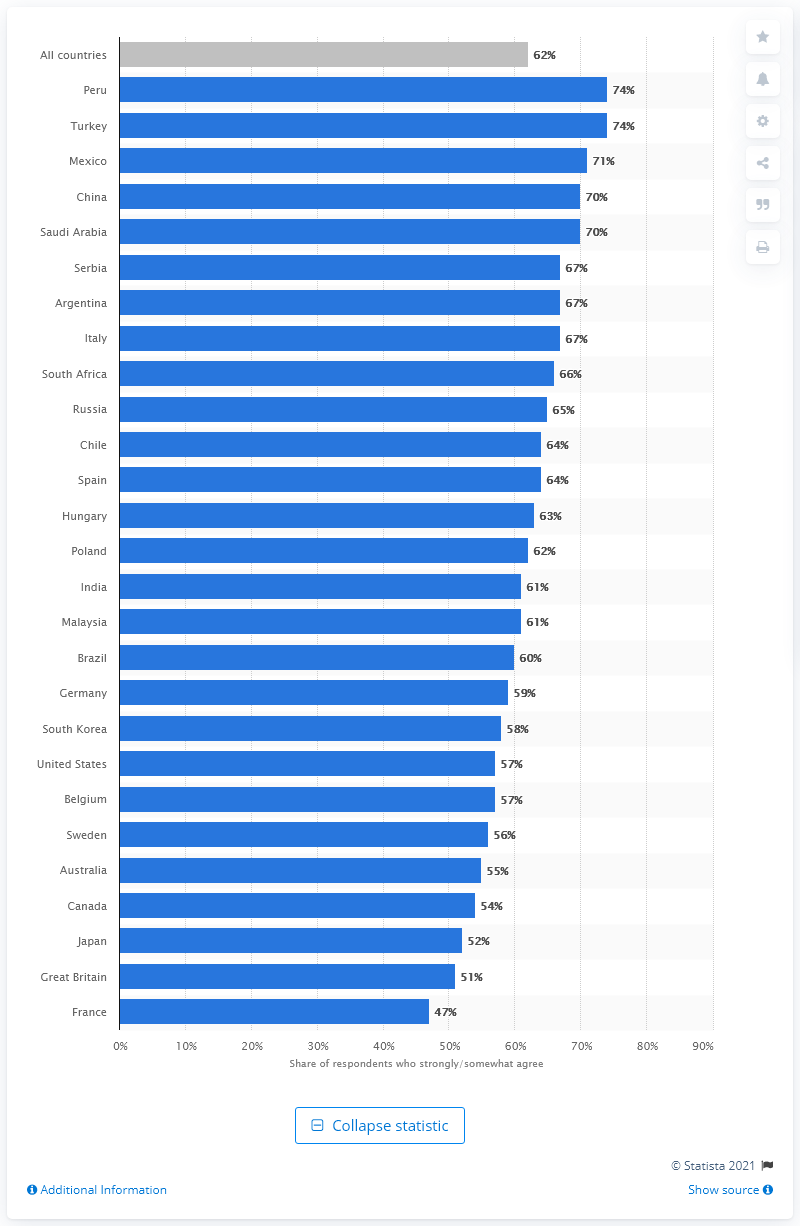

2. Title: Do you ever use social networking sites to share your views about
   Content: A survey of 20 countries conducted last spring by the Pew Research Center’s Global Attitudes Project found a median of 67% of social networkers say they use these sites to share opinions about music and movies. Significant numbers also post their views on community issues, sports and politics.
   Score: 1.4253817



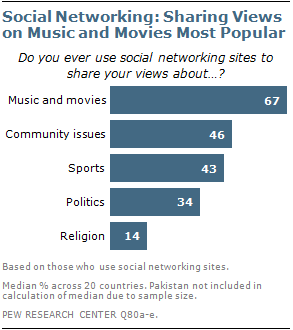

3. Title: 
                        Do you think the government should or should not regulate how social media companies safeguard the personal data of their users?
                    
   Content:  This statistic presents the view of individual's in the United States in regards to if the government should or should not regulate on how social media companies safeguard the personal data of their users. According to the April 2018 findings, 36 percent of surveyed respondents stated the government should regulate, while in comparison 30 percent reported the opposite, saying they should not. 
   Score: 1.4170759



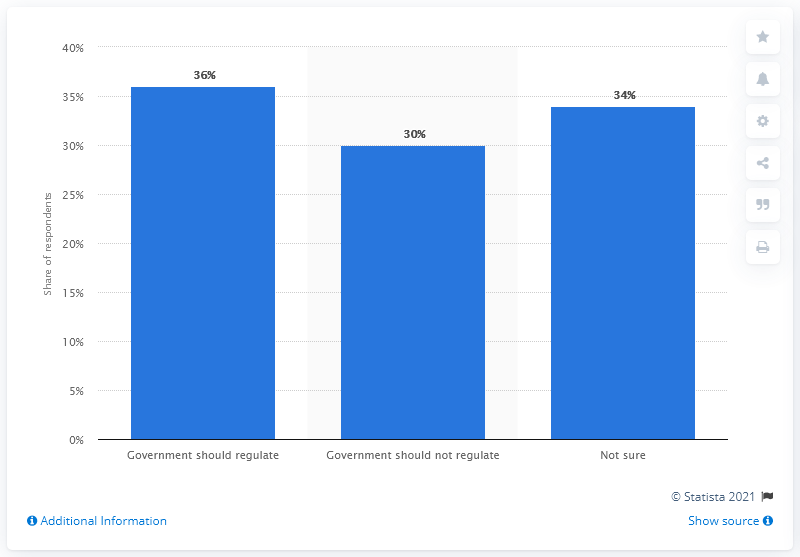

In [14]:
# Elasticsearch query to find relevant documents based on cosine similarity
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'gte_embedding')+ 1.00",
            "params": {"query_vector": query_embedding}
        }
    }
}
    
# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{question}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data
    image_bytes = base64.b64decode(doc['image_data'])
    
    # Open the image from bytes
    image = Image.open(io.BytesIO(image_bytes))
    
    # Display the image
    image.show()

In [3]:
# Clear CUDA cache
torch.cuda.empty_cache()